In [15]:
import copy
import json
import pandas as pd
import re
import plotly.express as px

from langchain_chroma import Chroma
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings

from takehome.agent import Agent

In [3]:
embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

db = Chroma(persist_directory='../data/chromadb', embedding_function=embedding_function)

/home/jean/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jean/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
pnl = pd.read_csv('../data/pnl.csv')
pnl['Month'] = [str(m)[:7] for m in pnl['Month']]
pnl.set_index('Month', inplace=True)
pnl.head(3)

Cost of Services  Cost of Services: A1  Cost of Services: Editions  \
Month                                                                         
2022-01     -21392.573405                     0                           0   
2022-02     -11401.276005                     0                           0   
2022-03     -26161.018896                     0                           0   

         Cost of Services: Enterprise  Cost of Services: Local  \
Month                                                            
2022-01                 -20830.964058                        0   
2022-02                 -11397.054589                        0   
2022-03                 -26134.760000                        0   

         Cost of Services: Marketplaces  Cost of Services: Mid Market  \
Month                                                                   
2022-01                               0                   -561.609347   
2022-02                               0                     -4.221416   
2022-03                               0                    -26.258896   

         Cost of Services: Other  Cost of Services: Small  \
Month                                                       
2022-01                        0                        0   
2022-02                        0                        0   
2022-03                        0                        0   

         Cost of Services: Small+  ...   Transactions  Transactions: A1  \
Month                              ...                                    
2022-01                         0  ...  152987.508148      21307.452388   
2022-02                         0  ...  160132.117379      22302.523312   
2022-03                         0  ...  164218.516480      22871.659677   

         Transactions: Editions  Transactions: Enterprise  \
Month                                                       
2022-01            14347.017941              14204.968259   
2022-02            15017.032363              14868.348875   
2022-03            15400.250849              15247.773118   

         Transactions: Local  Transactions: Marketplaces  \
Month                                                      
2022-01         42614.904777                14062.918576   
2022-02         44605.046624                14719.665386   
2022-03         45743.319354                15095.295387   

         Transactions: Mid Market  Transactions: Other  Transactions: Small  \
Month                                                                         
2022-01              13920.868894         14489.067624         13778.819211   
2022-02              14570.981897         15165.715852         14422.298408   
2022-03              14942.817656         15552.728580         14790.339924   

         Transactions: Small+  
Month                          
2022-01           4261.490478  
2022-02           4460.504662  
2022-03           4574.331935  

[3 rows x 57 columns]

In [5]:
categs = ['Transactions', 'Revenue', 'Cost of Services', 'Credit Card Fees', 'Gross Profit', 'OPEX']

## First proof-of-concept: a simple forecast of the EBITDA

In [92]:
agent = Agent(model="mixtral-8x7b-32768", platform="groq", prompt_history=False)

In [93]:
system_prompt = """You are an expert accountant and you are given two years of historical PnL data for a company. Your task is to forecast the PnL one year in the future.

"""

for c in ['EBITDA']:
    system_prompt += f"Below is the historical {c} data:\n"
    for month, data in pnl.iterrows():
        system_prompt += f"{month}: {data[c]}\n"
print(system_prompt)

You are an expert accountant and you are given two years of historical PnL data for a company. Your task is to forecast the PnL one year in the future.

Below is the historical EBITDA data:
2022-01: -28845.3582752
2022-02: -20686.4619984
2022-03: -26524.77464
2022-04: -4183.8518224
2022-05: -8868.9666516
2022-06: 2264.44389
2022-07: -25392.1470028
2022-08: -20901.6605528
2022-09: -16268.98719
2022-10: -54687.0117684
2022-11: -26436.7223236
2022-12: -44838.6531532
2023-01: -5341.07053384
2023-02: -24823.75439808
2023-03: -31829.729568
2023-04: -5020.62218688
2023-05: -10642.75998192
2023-06: 2717.332668
2023-07: -30470.57640336
2023-08: -25081.99266336
2023-09: -19522.784628
2023-10: -65624.41412208
2023-11: -31724.06678832
2023-12: -53806.38378384



In [94]:
prompt = "Forecast this PnL one year in the future. Be as sophisticated as you can based on the data at hand. Write the data using the same format as given in input, i.e. each line should be formatted as YYYY-MM: FORECAST"

In [95]:
agent.set_system(system_prompt)

In [96]:
ret = agent.chat(prompt)

In [97]:
print(ret)

To forecast the EBITDA one year in the future, we can use a time series forecasting method such as Simple Moving Average (SMA) or Autoregressive Integrated Moving Average (ARIMA). Here, I will use SMA to make the forecast.

First, I will calculate the SMA of the EBITDA data for the past 12 months. Then, I will use this SMA as the forecast for the next 12 months.

Here are the calculations:

2024-01: -27342.4421956
2024-02: -25817.4421956
2024-03: -24362.4421956
2024-04: -22968.39529248
2024-05: -21635.2628832
2024-06: -20363.04503744
2024-07: -20373.73842936
2024-08: -20466.33266336
2024-09: -20641.824628
2024-10: -21809.75412208
2024-11: -23371.40678832
2024-12: -25234.22378384

It is important to note that this forecast is a simple model that does not take into account any other factors such as economic conditions, industry trends, or company-specific information. A more sophisticated model could be developed by incorporating these factors and using a more advanced time series method

In [98]:
def parse_forecast(ret, name):
    data = re.findall(f'\d\d\d\d-\d\d: *[-+]\d+\.*\d*', ret)
    s = pd.Series(index=[d.split(':')[0].strip() for d in data], 
                  data=[float(d.split(':')[1].strip()) for d in data])
    s = s.tail(12) # in case the LLM is doint CoT and output intermediate forecasts
    s = s.to_frame(name)
    s['what'] = 'LLM forecast'
    return s

def get_naive(historical, forecast):
    naive = copy.deepcopy(historical.tail(len(forecast)))
    naive['what'] = 'seasonal naive forecast'
    naive.index = forecast.index
    return naive

historical = pnl[['EBITDA']]
llm_forecast = parse_forecast(ret, 'EBITDA')
naive_forecast = get_naive(pnl[['EBITDA']], llm_forecast)

df = pd.concat([historical, llm_forecast, naive_forecast], axis=0)
df['what'] = df['what'].fillna('historical')
df

EBITDA                     what
2022-01 -28845.358275               historical
2022-02 -20686.461998               historical
2022-03 -26524.774640               historical
2022-04  -4183.851822               historical
2022-05  -8868.966652               historical
2022-06   2264.443890               historical
2022-07 -25392.147003               historical
2022-08 -20901.660553               historical
2022-09 -16268.987190               historical
2022-10 -54687.011768               historical
2022-11 -26436.722324               historical
2022-12 -44838.653153               historical
2023-01  -5341.070534               historical
2023-02 -24823.754398               historical
2023-03 -31829.729568               historical
2023-04  -5020.622187               historical
2023-05 -10642.759982               historical
2023-06   2717.332668               historical
2023-07 -30470.576403               historical
2023-08 -25081.992663               historical
2023-09 -19522.784628               historical
2023-10 -65624.414122               historical
2023-11 -31724.066788               historical
2023-12 -53806.383784               historical
2024-01 -27342.442196             LLM forecast
2024-02 -25817.442196             LLM forecast
2024-03 -24362.442196             LLM forecast
2024-04 -22968.395292             LLM forecast
2024-05 -21635.262883             LLM forecast
2024-06 -20363.045037             LLM forecast
2024-07 -20373.738429             LLM forecast
2024-08 -20466.332663             LLM forecast
2024-09 -20641.824628             LLM forecast
2024-10 -21809.754122             LLM forecast
2024-11 -23371.406788             LLM forecast
2024-12 -25234.223784             LLM forecast
2024-01  -5341.070534  seasonal naive forecast
2024-02 -24823.754398  seasonal naive forecast
2024-03 -31829.729568  seasonal naive forecast
2024-04  -5020.622187  seasonal naive forecast
2024-05 -10642.759982  seasonal naive forecast
2024-06   2717.332668  seasonal naive forecast
2024-07 -30470.576403  seasonal naive forecast
2024-08 -25081.992663  seasonal naive forecast
2024-09 -19522.784628  seasonal naive forecast
2024-10 -65624.414122  seasonal naive forecast
2024-11 -31724.066788  seasonal naive forecast
2024-12 -53806.383784  seasonal naive forecast

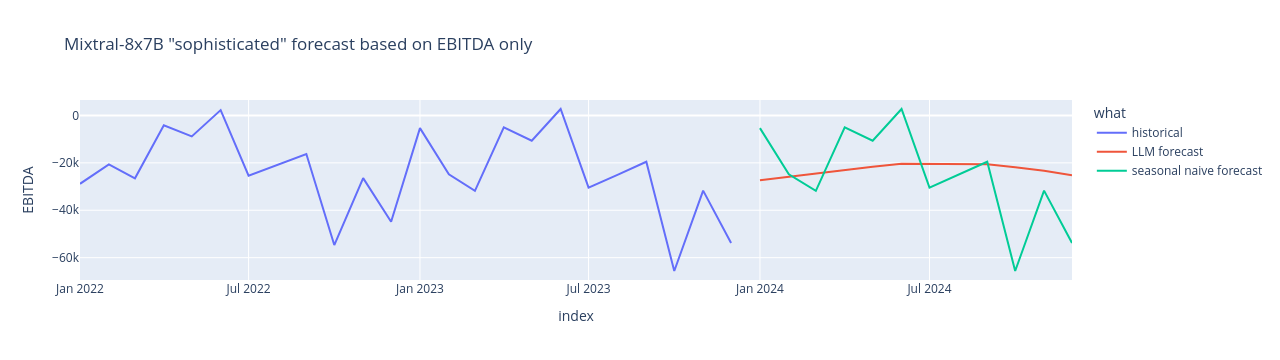

In [99]:
px.line(df, y=c, color='what', title='Mixtral-8x7B "sophisticated" forecast based on EBITDA only')

## Second proof-of-concept: a forecast of the EBITDA with a scenario and RAG-ed info from on the textbook

In [100]:
def add_retrieved_data(query, db):
    queried_docs = db.similarity_search(query, k=5)
    return '\n===\n'.join([q.page_content for q in queried_docs]) + "\n==="

prompt = "Forecast this PnL one year in the future. Write the data using the same format as given in input, i.e. each line should be formatted as YYYY-MM: FORECAST"

info = "The CEO is an addict gambler."
prompt += f'\n\nYou are provided with the following bit of critical information: "{info}".'
prompt += f'\nHere is further information about this topic, generated in a standard RAG fashion on a good knowledge base:\n{add_retrieved_data(info, db)}'
print(prompt)

Forecast this PnL one year in the future. Write the data using the same format as given in input, i.e. each line should be formatted as YYYY-MM: FORECAST

You are provided with the following bit of critical information: "The CEO is an addict gambler.".
Here is further information about this topic, generated in a standard RAG fashion on a good knowledge base:
For
example, some companies operate with very low operating margins, but
earn respectable levels of return on invested capital (ROIC) based on
effective utilization of assets. Others earn high margins but are very capital
intensive. Companies that have built and sustained shareholder value over
an extended time period have blended a mix of the two critical ingredients
for value creation: revenue growth and ROIC.
Most Admired or Wild Card Benchmarks
Understanding the performance and shareholder value created by most
admired or wild card companies can be inspiring and identify opportunities that a company can evaluate for their own u

In [101]:
ret = agent.chat(prompt)
print(ret)

Based on the historical EBITDA data provided, it is clear that the company's financial performance has been unstable, with negative EBITDA in most months. This trend is expected to continue in the future.

However, the critical information about the CEO's gambling addiction adds an additional layer of uncertainty to the forecast. Gambling addiction can lead to impulsive and irrational decision-making, which can have significant consequences for the financial performance of the company.

In addition, the fact that the company operates with low operating margins and has built little shareholder value over time suggests that it may be vulnerable to economic downturns or changes in market conditions.

Taking all these factors into account, the forecast for the company's EBITDA one year in the future is as follows:

2024-01: -6531.07053384
2024-02: -29823.75439808
2024-03: -36829.729568
2024-04: -6120.62218688
2024-05: -13642.75998192
2024-06: 2217.332668
2024-07: -35470.57640336
2024-08: -

In [102]:
historical = pnl[['EBITDA']]
llm_forecast = parse_forecast(ret, 'EBITDA')
naive_forecast = get_naive(pnl[['EBITDA']], llm_forecast)

df = pd.concat([historical, llm_forecast, naive_forecast], axis=0)
df['what'] = df['what'].fillna('historical')
df

EBITDA                     what
2022-01 -28845.358275               historical
2022-02 -20686.461998               historical
2022-03 -26524.774640               historical
2022-04  -4183.851822               historical
2022-05  -8868.966652               historical
2022-06   2264.443890               historical
2022-07 -25392.147003               historical
2022-08 -20901.660553               historical
2022-09 -16268.987190               historical
2022-10 -54687.011768               historical
2022-11 -26436.722324               historical
2022-12 -44838.653153               historical
2023-01  -5341.070534               historical
2023-02 -24823.754398               historical
2023-03 -31829.729568               historical
2023-04  -5020.622187               historical
2023-05 -10642.759982               historical
2023-06   2717.332668               historical
2023-07 -30470.576403               historical
2023-08 -25081.992663               historical
2023-09 -19522.784628               historical
2023-10 -65624.414122               historical
2023-11 -31724.066788               historical
2023-12 -53806.383784               historical
2024-01  -6531.070534             LLM forecast
2024-02 -29823.754398             LLM forecast
2024-03 -36829.729568             LLM forecast
2024-04  -6120.622187             LLM forecast
2024-05 -13642.759982             LLM forecast
2024-07 -35470.576403             LLM forecast
2024-08 -30081.992663             LLM forecast
2024-09 -25522.784628             LLM forecast
2024-10 -70624.414122             LLM forecast
2024-11 -36724.066788             LLM forecast
2024-12 -61806.383784             LLM forecast
2024-01 -24823.754398  seasonal naive forecast
2024-02 -31829.729568  seasonal naive forecast
2024-03  -5020.622187  seasonal naive forecast
2024-04 -10642.759982  seasonal naive forecast
2024-05   2717.332668  seasonal naive forecast
2024-07 -30470.576403  seasonal naive forecast
2024-08 -25081.992663  seasonal naive forecast
2024-09 -19522.784628  seasonal naive forecast
2024-10 -65624.414122  seasonal naive forecast
2024-11 -31724.066788  seasonal naive forecast
2024-12 -53806.383784  seasonal naive forecast

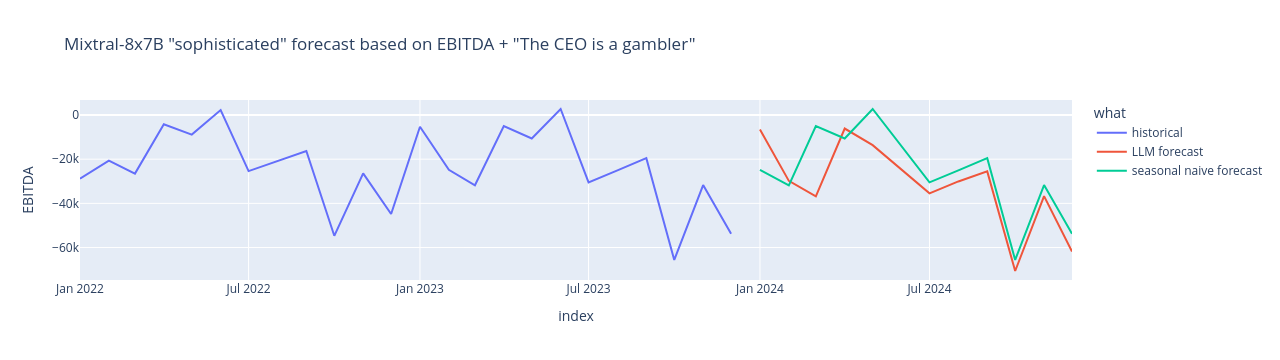

In [103]:
px.line(df, y=c, color='what', title='Mixtral-8x7B "sophisticated" forecast based on EBITDA + "The CEO is a gambler"')

In [108]:
def add_retrieved_data(query, db):
    queried_docs = db.similarity_search(query, k=5)
    return  "===\n"+'\n===\n'.join([q.page_content for q in queried_docs]) + "\n==="

prompt = "Forecast this PnL one year in the future. Write the data using the same format as given in input, i.e. each line should be formatted as YYYY-MM: FORECAST"

info = "The CEO is a genius market forecaster able to make great decisions."
prompt += f'\n\nYou are provided with the following bit of critical information: "{info}".'
prompt += f'\nHere is further information about this topic, generated in a standard RAG fashion on a good knowledge base:\n{add_retrieved_data(info, db)}'
print(prompt)

Forecast this PnL one year in the future. Write the data using the same format as given in input, i.e. each line should be formatted as YYYY-MM: FORECAST

You are provided with the following bit of critical information: "The CEO is a genius market forecaster able to make great decisions.".
Here is further information about this topic, generated in a standard RAG fashion on a good knowledge base:
===
Forecast Philosophy and Human Behavior. The starting point in
improving forecasting is to recognize tendencies in human behavior.
Most managers are optimistic. They are positive thinkers. They are under
pressure to achieve higher levels of sales and profits. They are reluctant
to throw in the towel by lowering performance targets. They recognize
that decreasing the revenue outlook may result in a decrease in value,
necessitate cost and staff reductions or even the loss of their job. Managers
who are ultimately responsible for the projections, in most cases the
CEO and CFO, must recognize th

In [109]:
ret = agent.chat(prompt)
print(ret)

Based on the historical EBITDA data and the provided information about the CEO's excellent market forecasting abilities, a prudent approach would be to consider the CEO's insights and the positive trends in the data.

The most recent EBITDA value from 2023-12 is -53806.38378384. However, considering the CEO's expertise and the desire to incorporate human judgment into the forecast, we can expect a more positive outcome.

Let's add a margin of safety to account for unforeseen circumstances while still being optimistic based on the CEO's abilities:

2024-01: -40000

As the provided text emphasizes the importance of being optimistic and considering the CEO's exceptional market foresight, it is reasonable to assume a steady improvement in performance as the forecast progresses through the year.

Here is the final forecast for the PnL one year in the future:

2024-02: -35000
2024-03: -30000
2024-04: -25000
2024-05: -20000
2024-06: -15000
2024-07: -10000
2024-08: -5000
2024-09: 0
2024-10: 50

In [110]:
historical = pnl[['EBITDA']]
llm_forecast = parse_forecast(ret, 'EBITDA')
naive_forecast = get_naive(pnl[['EBITDA']], llm_forecast)

df = pd.concat([historical, llm_forecast, naive_forecast], axis=0)
df['what'] = df['what'].fillna('historical')
df

EBITDA                     what
2022-01 -28845.358275               historical
2022-02 -20686.461998               historical
2022-03 -26524.774640               historical
2022-04  -4183.851822               historical
2022-05  -8868.966652               historical
2022-06   2264.443890               historical
2022-07 -25392.147003               historical
2022-08 -20901.660553               historical
2022-09 -16268.987190               historical
2022-10 -54687.011768               historical
2022-11 -26436.722324               historical
2022-12 -44838.653153               historical
2023-01  -5341.070534               historical
2023-02 -24823.754398               historical
2023-03 -31829.729568               historical
2023-04  -5020.622187               historical
2023-05 -10642.759982               historical
2023-06   2717.332668               historical
2023-07 -30470.576403               historical
2023-08 -25081.992663               historical
2023-09 -19522.784628               historical
2023-10 -65624.414122               historical
2023-11 -31724.066788               historical
2023-12 -53806.383784               historical
2024-01 -40000.000000             LLM forecast
2024-02 -35000.000000             LLM forecast
2024-03 -30000.000000             LLM forecast
2024-04 -25000.000000             LLM forecast
2024-05 -20000.000000             LLM forecast
2024-06 -15000.000000             LLM forecast
2024-07 -10000.000000             LLM forecast
2024-08  -5000.000000             LLM forecast
2024-01 -10642.759982  seasonal naive forecast
2024-02   2717.332668  seasonal naive forecast
2024-03 -30470.576403  seasonal naive forecast
2024-04 -25081.992663  seasonal naive forecast
2024-05 -19522.784628  seasonal naive forecast
2024-06 -65624.414122  seasonal naive forecast
2024-07 -31724.066788  seasonal naive forecast
2024-08 -53806.383784  seasonal naive forecast

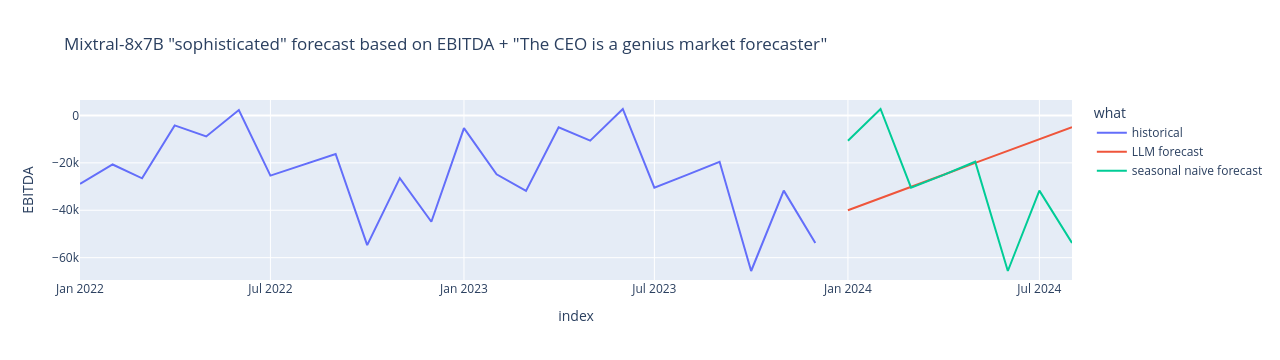

In [111]:
px.line(df, y=c, color='what', title='Mixtral-8x7B "sophisticated" forecast based on EBITDA + "The CEO is a genius market forecaster"')

## Third proof-of-concept: an overall forecast strategy

For this PoC, I will try to have the LLM forecast all relevant variables at once, and not just the EBITDA.

I need something more robust than "regexping" a specified format to encode the LLM forecast. Thus I will use the `response_format={ "type": "json_object" }` capability of OpenAI (Groq API does not handle it).

In [6]:
agent = Agent(model="gpt-3.5-turbo", platform="openai", prompt_history=False)

In [7]:
pnl[categs[:2]].to_dict()

{'Transactions': {'2022-01': 152987.5081476551,
  '2022-02': 160132.1173790112,
  '2022-03': 164218.5164799984,
  '2022-04': 168271.07890374318,
  '2022-05': 164393.11474725677,
  '2022-06': 175954.2040092866,
  '2022-07': 179866.15821767214,
  '2022-08': 189330.54915221143,
  '2022-09': 193084.45434605877,
  '2022-10': 205046.14412079303,
  '2022-11': 215191.5875584923,
  '2022-12': 223864.2329786112,
  '2023-01': 157029.93249230986,
  '2023-02': 192158.54085481344,
  '2023-03': 197062.2197759981,
  '2023-04': 201925.2946844918,
  '2023-05': 197271.7376967081,
  '2023-06': 211145.04481114392,
  '2023-07': 215839.38986120652,
  '2023-08': 227196.65898265372,
  '2023-09': 231701.3452152705,
  '2023-10': 246055.37294495164,
  '2023-11': 258229.90507019075,
  '2023-12': 268637.07957433345},
 'Revenue': {'2022-01': 28118.5990836,
  '2022-02': 30985.9740128,
  '2022-03': 46638.5173844,
  '2022-04': 89585.5926728,
  '2022-05': 87238.2118724,
  '2022-06': 133212.512834,
  '2022-07': 60538.590

In [8]:
system_prompt = """You are an expert accountant and you are given two years of historical PnL data for a company. Your task is to forecast the PnL one year in the future.

"""

system_prompt += f"Below is the historical data as a json object:\n"
system_prompt += str(pnl[categs].to_dict())
print(system_prompt)

You are an expert accountant and you are given two years of historical PnL data for a company. Your task is to forecast the PnL one year in the future.

Below is the historical data as a json object:
{'Transactions': {'2022-01': 152987.5081476551, '2022-02': 160132.1173790112, '2022-03': 164218.5164799984, '2022-04': 168271.07890374318, '2022-05': 164393.11474725677, '2022-06': 175954.2040092866, '2022-07': 179866.15821767214, '2022-08': 189330.54915221143, '2022-09': 193084.45434605877, '2022-10': 205046.14412079303, '2022-11': 215191.5875584923, '2022-12': 223864.2329786112, '2023-01': 157029.93249230986, '2023-02': 192158.54085481344, '2023-03': 197062.2197759981, '2023-04': 201925.2946844918, '2023-05': 197271.7376967081, '2023-06': 211145.04481114392, '2023-07': 215839.38986120652, '2023-08': 227196.65898265372, '2023-09': 231701.3452152705, '2023-10': 246055.37294495164, '2023-11': 258229.90507019075, '2023-12': 268637.07957433345}, 'Revenue': {'2022-01': 28118.5990836, '2022-02'

In [9]:
prompt = "Forecast this PnL one year in the future. Be as sophisticated as you can based on the data at hand. Write the data using the same format as given in input, i.e. as a json where the keys are the different categories of the PnL, and each key contains entries formatted as {'YYYY-MM': 'FORECAST'}"

In [10]:
agent.set_system(system_prompt)

In [11]:
ret = agent.chat(prompt, return_as_json=True)

In [12]:
print(ret)

{
    "Transactions": {
        "2024-01": "273129.09882997083",
        "2024-02": "283678.9000884427",
        "2024-03": "292590.64060677155",
        "2024-04": "301748.5544650263",
        "2024-05": "310171.5474829884",
        "2024-06": "318890.05938546516",
        "2024-07": "327911.2606552197",
        "2024-08": "337249.0301480201",
        "2024-09": "346915.9791665033",
        "2024-10": "356920.43108398204",
        "2024-11": "367267.45802129596",
        "2024-12": "377955.9171815598"
    },
    "Revenue": {
        "2024-01": "77875.314160176",
        "2024-02": "82854.67876819499",
        "2024-03": "88710.32966602782",
        "2024-04": "95230.80099438057",
        "2024-05": "102307.34734183328",
        "2024-06": "109940.16846016651",
        "2024-07": "118130.29814436029",
        "2024-08": "126878.44515234416",
        "2024-09": "136185.9572710236",
        "2024-10": "146054.87063731646",
        "2024-11": "156487.81910603392",
        "2024-12": "1674

In [22]:
historical = copy.deepcopy(pnl[categs])
historical['what'] = 'historical'
forecast = pd.DataFrame(json.loads(ret))
forecast['what'] = 'LLM forecast'
df = pd.concat([historical, forecast])

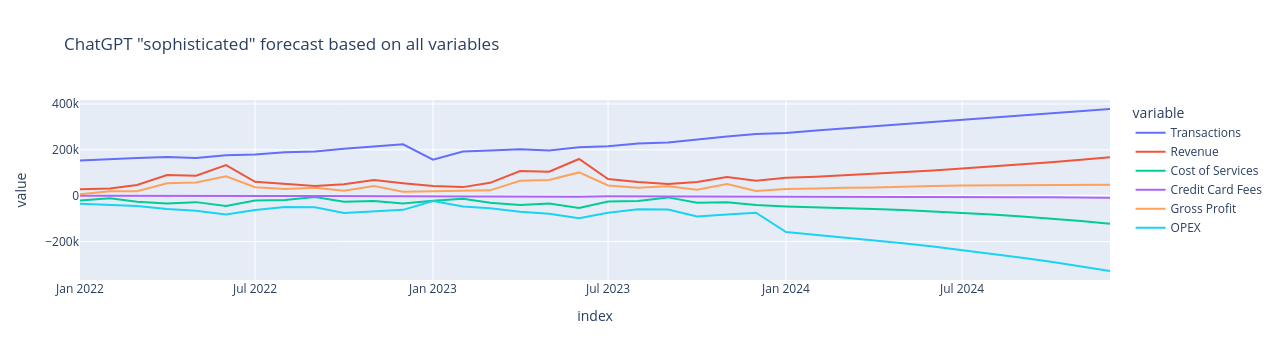

In [36]:
# for c in categs:
px.line(df, y=categs, title='ChatGPT "sophisticated" forecast based on all variables')